In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set a random number for the project
rng = np.random.RandomState(6004)

# Data Discovery and Preprocessing

In [3]:
data = pd.read_csv('sph6004_assignment1_data.csv')
data.head()

,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,NaN,236.0,318.0,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,39307659,0,F,78.194169,WHITE - RUSSIAN,72.0,134.0,97.263158,97.0,127.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,38743306,2,F,65.602396,WHITE,60.0,97.0,84.166667,95.0,143.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,32339865,2,F,64.906629,UNKNOWN,59.0,87.0,71.461538,113.0,150.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,35526987,2,M,57.438861,WHITE,57.0,100.0,82.387097,81.0,127.0,...,NaN,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


In [4]:
data.shape

(50920, 162)

In [5]:
# classify the aki
data.loc[data['aki'].isin([0, 1]), 'aki'] = 0
data.loc[~data['aki'].isin([0, 1]), 'aki'] = 1

In [6]:
# encoding gender
data.loc[data['gender'] == 'F', 'gender'] = 1
data.loc[data['gender'] == 'M', 'gender'] = 0

In [7]:
# drop id and race columns
data = data.drop(columns=['id', 'race'])

In [8]:
missing = data.isnull().sum()

In [9]:
# to test several possible key features
# low_risk = data[data['aki'] == 0]
# high_risk = data[data['aki'] == 1]
# lst = ['bicarbonate_min', 'bicarbonate_max', 'hemoglobin_min', 'hemoglobin_max', 'chloride_min', 'chloride_max', 'calcium_min', 'calcium_max']

# for l in lst:
#     print(low_risk[l].mean(), high_risk[l].mean())

In [10]:
# drop half missing indices
half_missing = missing[missing >= len(data)/2].index.tolist()
data = data.drop(columns=half_missing)
data.shape

(50920, 85)

In [11]:
# split train & test before preprocessing
from sklearn.model_selection import train_test_split

X = data.drop('aki', axis=1)
y = data['aki']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)

In [12]:
# using the mean values of training data to fill the dataset
train_means = X_train.mean()
X_train = X_train.fillna(train_means)
X_test = X_test.fillna(train_means)

# Feature Selection

## Statistics

In [13]:
# numerical features
num = X_train.columns[1:]
X_num_train = X_train[num]
X_num_test = X_test[num]

In [14]:
# using correlation analysis to select features, but all the features show a low relationship with aki
data_scaled = pd.concat([X_num_train, y_train], axis=1)
corr = data_scaled.corr()
threshold = 0.5
high_corr = corr['aki'][abs(corr['aki']) > threshold].index.tolist()
high_corr

['aki']

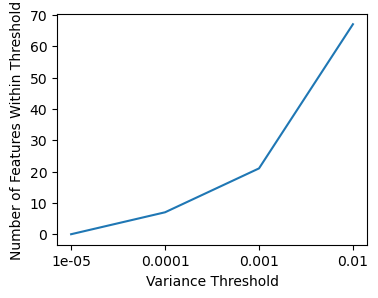

In [15]:
# variance analysis

# Max-min normalisation
from sklearn import preprocessing

maxmin_scaler = preprocessing.MinMaxScaler()
fit_scaler = maxmin_scaler.fit(X_num_train)

train_num_scaled = fit_scaler.transform(X_num_train)
train_num_scaled = pd.DataFrame(train_num_scaled, columns=X_num_train.columns)

var = train_num_scaled.var().values

var_fre = [len(var[var < 10**(-i)]) for i in range(5, 1, -1)]
x = [i for i in range(4)]
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(x, var_fre)
plt.xticks(x, [10**(-i) for i in range(5, 1, -1)])
plt.xlabel('Variance Threshold')
plt.ylabel('Number of Features Within Threshold')
plt.show()

In [16]:
# Compared the variance to select features
from sklearn.feature_selection import VarianceThreshold

threshold = 0.001

selector = VarianceThreshold(threshold=threshold)

X_var_selected = selector.fit_transform(train_num_scaled)

var_selected = train_num_scaled.columns[selector.get_support()]
print(len(var_selected))

62


In [17]:
# t-test
from scipy.stats import ttest_ind

low_risk = data_scaled[data_scaled['aki'] == 0]
high_risk = data_scaled[data_scaled['aki'] == 1]
ttest_selected = []

for c in data_scaled.columns:
    t_statistic, p_value = ttest_ind(low_risk[c], high_risk[c])
    if p_value < 0.05:
        ttest_selected.append(c)

print(len(ttest_selected))

73


d:\Anaconda\Anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## RFE

In [18]:
# Z-score standardization
scaler = preprocessing.StandardScaler()
fit_scaler = scaler.fit(X_num_train)

train_num_scaled = fit_scaler.transform(X_num_train)
test_num_scaled = fit_scaler.transform(X_num_test)

In [19]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty='l1', C=1/5, solver='liblinear', random_state=rng)
rfe = RFE(log_reg, n_features_to_select=20)
fit = rfe.fit(train_num_scaled, y_train)

rfe_selected = X_num_train.columns[fit.support_]

## Random Forest

In [20]:
# feature selection

from sklearn.ensemble import RandomForestClassifier

n_selected = 20

rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=rng)
rf_model.fit(train_num_scaled, y_train)

feature_importances = rf_model.feature_importances_
feature_importances = pd.concat([
                                pd.DataFrame({'feature': X_num_train.columns}),
                                pd.DataFrame({'importance': feature_importances})], 
                                axis=1)
rf_selected = feature_importances.sort_values(by='importance', ascending=False).head(n_selected)['feature']

## Result

In [40]:
# with RFE
intersect_rfe = list(set(var_selected) & set(ttest_selected) & set(rfe_selected))
print(len(intersect_rfe))
sorted(intersect_rfe)

19


['admission_age',
 'bicarbonate_max.1',
 'bicarbonate_min.1',
 'bun_min',
 'chloride_max.1',
 'dbp_mean',
 'gcs_verbal',
 'heart_rate_max',
 'heart_rate_mean',
 'heart_rate_min',
 'hematocrit_max.1',
 'hemoglobin_max.1',
 'mbp_mean',
 'platelets_max',
 'platelets_min',
 'sbp_max',
 'sbp_mean',
 'sbp_min',
 'temperature_max']

In [41]:
# with random forest
intersect_rf = list(set(var_selected) & set(ttest_selected) & set(rf_selected))
print(len(intersect_rf))
sorted(intersect_rf)

15


['admission_age',
 'bun_max',
 'bun_min',
 'dbp_mean',
 'dbp_min',
 'glucose_max.2',
 'heart_rate_mean',
 'mbp_min',
 'po2_min',
 'pt_max',
 'ptt_max',
 'resp_rate_mean',
 'sbp_max',
 'sbp_mean',
 'sbp_min']

In [42]:
print(len(set(intersect_rfe) & set(intersect_rf)))

7


# Modeling

## Functions for modeling

In [23]:
# merge the numeric features with category features
def merge_data(feature_selected):
    overall_selected = list(set(var_selected) & set(ttest_selected) & set(feature_selected))
    train_scaled = pd.DataFrame(train_num_scaled, columns=num)[overall_selected]
    test_scaled = pd.DataFrame(test_num_scaled, columns=num)[overall_selected]

    train_scaled['gender'] = X_train['gender'].to_numpy()
    test_scaled['gender'] = X_test['gender'].to_numpy()
    return train_scaled, test_scaled

In [24]:
# Grid Search for hyperparameters
from sklearn.model_selection import GridSearchCV

def grid_search(X_train, y_train, model, param, cv=2, scoring='recall'):
    search = GridSearchCV(model, param, cv=cv, scoring=scoring)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    return best_model

In [29]:
# Model Evaluation
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

def plot_confusion_matrix(cm, model):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {model}')
    plt.show()


def model_evaluate(pred, test, model):
    acc = accuracy_score(test, pred)
    recall = recall_score(test, pred)
    class_report = classification_report(test, pred, labels=[0, 1])
    cm = confusion_matrix(test, pred, normalize='true')

    print(f"Accuracy: {acc:.3f}, ", f"Recall: {recall:.3f}, ")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix (Percentage):")
    plot_confusion_matrix(cm, model)

## Logistic Regression

Accuracy: 0.635,  Recall: 0.603, 

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      5340
           1       0.62      0.60      0.61      4844

    accuracy                           0.64     10184
   macro avg       0.63      0.63      0.63     10184
weighted avg       0.63      0.64      0.63     10184


Confusion Matrix (Percentage):


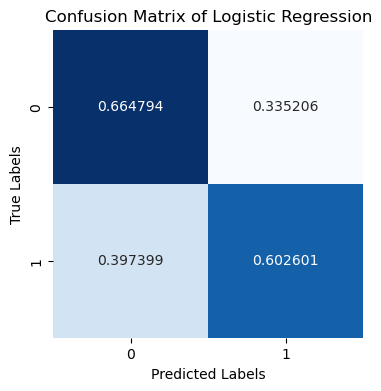

In [30]:
train, test = merge_data(rfe_selected)

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.2, 1, 10],
    'penalty': ['l1', 'l2'],
}

log_reg = LogisticRegression(solver='liblinear', random_state=rng)

logreg_best = grid_search(train, y_train, log_reg, param_grid)
logreg_best.fit(train, y_train)

y_pred = logreg_best.predict(test)

model_evaluate(y_pred, y_test, model='Logistic Regression')

In [27]:
# logreg_model = LogisticRegression(penalty='l2', C=0.01, solver='saga')
logreg_best

LogisticRegression(C=0.001, penalty='l1',
                   random_state=RandomState(MT19937) at 0x1B92C5CAD40,
                   solver='liblinear')

## AdaBoost

Accuracy: 0.631,  Recall: 0.568, 

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      5340
           1       0.62      0.57      0.59      4844

    accuracy                           0.63     10184
   macro avg       0.63      0.63      0.63     10184
weighted avg       0.63      0.63      0.63     10184


Confusion Matrix (Percentage):


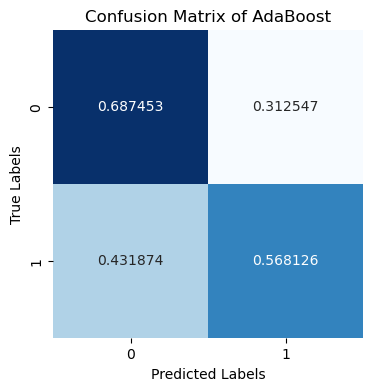

In [31]:
from sklearn.ensemble import AdaBoostClassifier

train, test = merge_data(rfe_selected)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2, 0.5]
}

base = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=rng)
ada_model = AdaBoostClassifier(base, random_state=rng)

ada_best = grid_search(train, y_train, ada_model, param_grid)
ada_best.fit(train, y_train)

y_pred = ada_best.predict(test)

model_evaluate(y_pred, y_test, model='AdaBoost')

In [ ]:
ada_best

AdaBoostClassifier(estimator=LogisticRegression(C=1,
                                                random_state=RandomState(MT19937) at 0x19C1BDC8B40,
                                                solver='liblinear'),
                   learning_rate=0.01,
                   random_state=RandomState(MT19937) at 0x19C1BDC8A40)

## SVM

Accuracy: 0.624,  Recall: 0.505, 

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      5340
           1       0.63      0.50      0.56      4844

    accuracy                           0.62     10184
   macro avg       0.63      0.62      0.62     10184
weighted avg       0.63      0.62      0.62     10184


Confusion Matrix (Percentage):


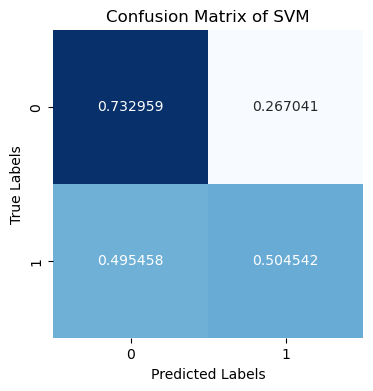

In [32]:
from sklearn.svm import SVC

train, test = merge_data(rf_selected)

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.2, 1]
}

svc_model = SVC(kernel='linear', random_state=rng)

svc_best = grid_search(train, y_train, svc_model, param_grid)
svc_best.fit(train, y_train)

y_pred = svc_best.predict(test)

model_evaluate(y_pred, y_test, model='SVM')

In [ ]:
svc_best

SVC(C=1, kernel='linear', random_state=RandomState(MT19937) at 0x19C1BDC9240)

## Random Forest

Accuracy: 0.657,  Recall: 0.605, 

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      5340
           1       0.65      0.60      0.63      4844

    accuracy                           0.66     10184
   macro avg       0.66      0.65      0.65     10184
weighted avg       0.66      0.66      0.66     10184


Confusion Matrix (Percentage):


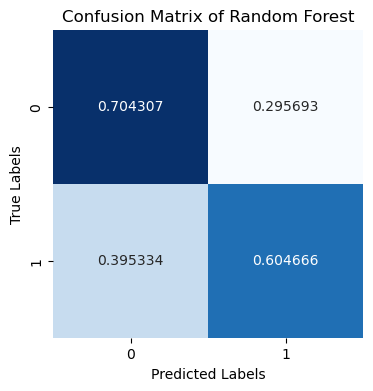

In [33]:
train, test = merge_data(rf_selected)

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15]
}

rf_model = RandomForestClassifier(random_state=rng)

rf_best = grid_search(train, y_train, rf_model, param_grid)
rf_best.fit(train, y_train)

y_pred = rf_best.predict(test)

model_evaluate(y_pred, y_test, model="Random Forest")

In [ ]:
rf_best

RandomForestClassifier(max_depth=15, n_estimators=200,
                       random_state=RandomState(MT19937) at 0x19C27212440)